# 0. Import Library

In [25]:
import numpy as np
import pandas as pd
import random

from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error, root_mean_squared_error
import optuna
from catboost import CatBoostRegressor

# 1. Business Understanding

# 2. Data Understanding

## 2.1 Load Data dan Cetak Atribut Tabel

In [5]:
dataUser = pd.read_csv("Data/Users.csv")
dataBuku = pd.read_csv("Data/Books.csv")
dataRating = pd.read_csv("Data/Ratings.csv")

dataUser.info()
dataBuku.info()
dataRating.info()

/tmp/ipykernel_15195/182713458.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  dataBuku = pd.read_csv("Data/Books.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)


## 2.2 Identifikasi Karakteristik Data dan Cetak Ringkasan Statistik

In [6]:
dataUser = dataUser.rename(columns={
    'User-ID': 'userID'
})
dataRating = dataRating.rename(columns={
    'User-ID': 'userID'
})

print('Banyak User : ', len(dataUser.userID.unique()))
print('Banyak Buku : ', len(dataBuku.ISBN.unique()))
print('Banyak User yang Memberi Rating : ', len(dataRating.userID.unique()))

Banyak User :  278858
Banyak Buku :  271360
Banyak User yang Memberi Rating :  105283


## 2.3 Identifikasi Ringkasan Statistik Data

### 2.3.1 Ringkasan Statistik Dataset Books

In [7]:
dataBuku.drop(columns=['Image-URL-S','Image-URL-M','Image-URL-L','ISBN']).describe(include='all')

,Book-Title,Book-Author,Year-Of-Publication,Publisher
count,271360,271358,271360,271358
unique,242135,102022,202,16807
top,Selected Poems,Agatha Christie,2002,Harlequin
freq,27,632,13903,7535


### 2.3.2 Ringkasan Statistik Dataset Ratings

In [8]:
dataRating.drop(columns=['userID']).describe(include='all')

,ISBN,Book-Rating
count,1149780,1.149780e+06
unique,340556,NaN
top,0971880107,NaN
freq,2502,NaN
mean,NaN,2.866950e+00
std,NaN,3.854184e+00
min,NaN,0.000000e+00
25%,NaN,0.000000e+00
50%,NaN,0.000000e+00
75%,NaN,7.000000e+00


### 2.3.3 Ringkasan Statistik Dataset Users

In [9]:
dataUser.drop(columns=['userID']).describe(include='all')

,Location,Age
count,278858,168096.000000
unique,57339,NaN
top,"london, england, united kingdom",NaN
freq,2506,NaN
mean,NaN,34.751434
std,NaN,14.428097
min,NaN,0.000000
25%,NaN,24.000000
50%,NaN,32.000000
75%,NaN,44.000000


## 2.4 Pengecekan Missing Value

In [10]:
dataUser.isnull().sum()

userID           0
Location         0
Age         110762
dtype: int64

**Penjelasan :**

Pada dataset Buku terlihat terdapat missing value pada data yaitu pada kolom Age. Hal ini menunjukkan diperlukan perlakuan agar tidak mengganggu analisis selanjutnya.

In [11]:
dataBuku.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

**Penjelasan :**

Pada dataset Buku terlihat terdapat missing value pada data yaitu pada kolom Book-Author, Publisher, dan Image-URL-L. Hal ini menunjukkan diperlukan perlakuan agar tidak mengganggu analisis selanjutnya.

In [13]:
dataRating.isnull().sum()

userID         0
ISBN           0
Book-Rating    0
dtype: int64

**Penjelasan :**

Pada dataset rating terlihat tidak terdapat missing value pada data.

# 3. Data Preparation

## 3.1 Join Tabel

In [14]:
# Gabungkan Data Rating dengan Data User untuk memperoleh dataset rating beserta atribut usernya
dataRatingUser = pd.merge(dataRating, dataUser, on='userID', how='left')
# Gabungkan dataset sebelumnya dengan dataset buku untuk memperoleh keterangan buku yang diberi rating
dataset = pd.merge(dataRatingUser, dataBuku, on='ISBN', how='left')

In [15]:
dataset.info()
dataset.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   userID               1149780 non-null  int64  
 1   ISBN                 1149780 non-null  object 
 2   Book-Rating          1149780 non-null  int64  
 3   Location             1149780 non-null  object 
 4   Age                  840288 non-null   float64
 5   Book-Title           1031136 non-null  object 
 6   Book-Author          1031134 non-null  object 
 7   Year-Of-Publication  1031136 non-null  object 
 8   Publisher            1031134 non-null  object 
 9   Image-URL-S          1031136 non-null  object 
 10  Image-URL-M          1031136 non-null  object 
 11  Image-URL-L          1031132 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 105.3+ MB


userID                      0
ISBN                        0
Book-Rating                 0
Location                    0
Age                    309492
Book-Title             118644
Book-Author            118646
Year-Of-Publication    118644
Publisher              118646
Image-URL-S            118644
Image-URL-M            118644
Image-URL-L            118648
dtype: int64

## 3.2 Eliminasi Observasi dengan Missing Value

In [16]:
dataFinal = dataset.dropna()

**Penjelasan :**

Setelah proses joining table, data missing value yang masih ada diberi perlakuan berupa Eliminasi Observasi. Hal ini bertujuan untuk tidak memberikan bias pada data jika dilakukan imputasi. Bias dapat muncul karena jumlah missing value yang cukup besar, sehingga berisiko jika diimputasi.

### 3.3.1 Preprocessing untuk Content Based Filtering

In [17]:
# Membentuk Variabel Baru yang menangkap atribut dari Buku
dataFinal['AtributBuku'] = dataFinal['Book-Title'] + ' ' + dataFinal['Book-Author'] + ' ' + dataFinal['Year-Of-Publication'].astype(str)

# Preprocessing: Convert to lowercase, remove punctuation
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

dataFinal['AtributBuku'] = dataFinal['AtributBuku'].apply(preprocess_text)

# Undersampling untuk Reduksi Dataset
dataBaru = dataFinal.dropna(subset=['AtributBuku']).sample(n=90000, random_state=42).reset_index(drop=True)

/tmp/ipykernel_15195/3961848135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFinal['AtributBuku'] = dataFinal['Book-Title'] + ' ' + dataFinal['Book-Author'] + ' ' + dataFinal['Year-Of-Publication'].astype(str)
/tmp/ipykernel_15195/3961848135.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFinal['AtributBuku'] = dataFinal['AtributBuku'].apply(preprocess_text)


### 3.3.2 Preprocessing untuk Colaborative Filtering

In [19]:
# Mengubah userID menjadi list unik
user_ids = dataFinal['userID'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

# Mengubah ISBN menjadi list unik
buku_ids = dataFinal['ISBN'].unique().tolist()
buku_to_ids_encoded = {x: i for i, x in enumerate(buku_ids)}
ids_to_buku_encoded = {i: x for i, x in enumerate(buku_ids)}

# Melakukan encoding ke dataframe
dataFinal['user_encoded'] = dataFinal['userID'].map(user_to_user_encoded)
dataFinal['ISBN_encoded'] = dataFinal['ISBN'].map(buku_to_ids_encoded)

# Cek apakah ada yang gagal di-encode
if dataFinal[['user_encoded', 'ISBN_encoded']].isnull().values.any():
    print("🚨 Ada userID atau ISBN yang tidak berhasil di-encode!")
    print("Jumlah user_encoded NaN:", dataFinal['user_encoded'].isnull().sum())
    print("Jumlah ISBN_encoded NaN:", dataFinal['ISBN_encoded'].isnull().sum())
    # Bisa drop baris NaN atau isi dengan nilai default
    dataFinal = dataFinal.dropna(subset=['user_encoded', 'ISBN_encoded'])

# Convert ke integer untuk keperluan input model embedding
dataFinal['user_encoded'] = dataFinal['user_encoded'].astype(np.int32)
dataFinal['ISBN_encoded'] = dataFinal['ISBN_encoded'].astype(np.int32)

# Konversi rating ke float32
dataFinal['Book-Rating'] = dataFinal['Book-Rating'].astype(np.float32)

# Info statistik
num_users = len(user_to_user_encoded)
num_items = len(ids_to_buku_encoded)
min_rating = dataFinal['Book-Rating'].min()
max_rating = dataFinal['Book-Rating'].max()

print(f'Jumlah User: {num_users}, Jumlah Buku: {num_items}, Min Rating: {min_rating}, Max Rating: {max_rating}')

/tmp/ipykernel_15195/3581592387.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFinal['user_encoded'] = dataFinal['userID'].map(user_to_user_encoded)


Jumlah User: 53887, Jumlah Buku: 228995, Min Rating: 0.0, Max Rating: 10.0


/tmp/ipykernel_15195/3581592387.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFinal['ISBN_encoded'] = dataFinal['ISBN'].map(buku_to_ids_encoded)
/tmp/ipykernel_15195/3581592387.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFinal['user_encoded'] = dataFinal['user_encoded'].astype(np.int32)
/tmp/ipykernel_15195/3581592387.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [20]:
# Mengacak dataset
df = dataFinal.sample(frac=1, random_state=42)
df

# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = df[['user_encoded', 'ISBN_encoded']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

# 4. Modelling

## 4.1 Content Based Filtering

### 4.1.1 Membentuk Matriks Term Frequency - Inverse Document Frequency

In [16]:
# Buat dataframe baru berisi data unik dari AtributBuku
dataBaru = dataBaru.drop_duplicates(subset='AtributBuku').reset_index(drop=False)

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(dataBaru['AtributBuku'])

### 4.1.2 Membentuk Matriks Cosine Similarity

In [17]:
cosine_sim = cosine_similarity(tfidf_matrix, dense_output=False)


### 4.1.3 Pendefinisian Fungsi Rekomendasi Produk

In [18]:
def recommend(book_title, cosine_sim=cosine_sim, jmlbuku = 5):
    print(f"Menampilkan Rekomendasi Buku yang sesuai dengan '{book_title}' ...")
    
    matches = dataBaru[dataBaru['Book-Title'] == book_title]
    if matches.empty:
        return f"Tidak ditemukan judul: {book_title}"
    
    # matches.index sudah 0..n-1, cocok untuk cosine_sim
    idx = matches.index[0]

    sim_scores_row = cosine_sim[idx].toarray().flatten()

    sim_scores = list(enumerate(sim_scores_row))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:jmlbuku+1]  # skip buku itu sendiri

    book_indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]

    result = dataBaru.iloc[book_indices][['Book-Title', 'Book-Author', 'Publisher', 'Year-Of-Publication']].copy()
    result['similarity_score'] = scores

    return result.reset_index(drop=True)


In [19]:
recommend(dataBaru['Book-Title'].dropna().sample(1).iloc[0])


Menampilkan Rekomendasi Buku yang sesuai dengan 'Life in the Rainforests (Life in the Series)' ...


,Book-Title,Book-Author,Publisher,Year-Of-Publication,similarity_score
0,Life 101 : Everything We Wish We Had Learned A...,Peter McWilliams,Prelude Press,1997,0.295976
1,Life 101: Everything We Wish We Had Learned Ab...,Peter McWilliams,Prelude Press,1994,0.283014
2,Once in Every Life,Kristin Hannah,Ballantine Books,1993,0.261591
3,LIFE AFTER GOD : LIFE AFTER GOD,Douglas Coupland,Washington Square Press,1995,0.248410
4,Life Out There: The Truth Of- And Search For- ...,Michael White,Ecco Press,1999,0.246720


**Penjelasan :**

Terlihat bahwa sistem rekomendasi yang dibangun dengan Content Based Filtering dapat mengembalikan buku yang memiliki karakteristik mirip dengan inputan yang diberikan. Pada pengujian tersebut, diberikan judul 'Life in the Rainforests (Life in the Series)' yang digunakan sebagai input ke fungsi. Terlihat bahwa fungsi mengembalikan 5 buku yang memiliki similarity tertinggi dengan judul sebelumnya. Terlihat pada Gambar 4, Nilai cosine similarity tertinggi yaitu 0,29 pada buku berjudul Life 101 : Everything We Wish We Had Learned A yang ditulis oleh author Peter McWilliams. Kesamaan judul ini dapat menjadi penyebab buku tersebut menjadi hasil kembalian fungsi. 

## 4.2 Collaborative Filtering

### 4.2.1 Pendefinisian Model RecommenderNet (Neural Colaborative Filtering)

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model

class RecommenderNet(Model):

    def __init__(self, num_users, num_buku, embedding_size, dropout_rate=0.3, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_buku = num_buku
        self.embedding_size = embedding_size
        self.dropout_rate = dropout_rate

        # User Embedding Layer
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(input_dim=num_users, output_dim=1)

        # Item Embedding Layer
        self.buku_embedding = layers.Embedding(
            input_dim=num_buku,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.buku_bias = layers.Embedding(input_dim=num_buku, output_dim=1)

        # Dropout Layer
        self.dropout = layers.Dropout(dropout_rate)

        # Fully Connected Layer
        self.fc1 = layers.Dense(embedding_size, activation='relu')
        self.batch_norm = layers.BatchNormalization()
        self.fc2 = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        # Extract user and item embeddings
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        buku_vector = self.buku_embedding(inputs[:, 1])
        buku_bias = self.buku_bias(inputs[:, 1])

        # Normalize embeddings
        user_vector = tf.nn.l2_normalize(user_vector, axis=1)
        buku_vector = tf.nn.l2_normalize(buku_vector, axis=1)

        # Compute dot product
        dot_product = tf.reduce_sum(user_vector * buku_vector, axis=1, keepdims=True)

        # Add biases
        x = dot_product + user_bias + buku_bias

        # Apply dropout and dense layers
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = self.fc2(x)

        return x

In [21]:
model = RecommenderNet(num_users, num_items, 1024) # inisialisasi model
 
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

I0000 00:00:1747893042.557678      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


### 4.2.2 Pelatihan Model Rekomendasi

In [22]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 1024,
    epochs = 10,
    validation_data = (x_val, y_val)
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 234490880 elements. This may consume a large amount of memory.
  warnings.warn(
I0000 00:00:1747893047.983210     101 service.cc:148] XLA service 0x7ad8bc00bb00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747893047.983650     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747893048.269770     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/589 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.2067 - rmse: 0.4501  

I0000 00:00:1747893049.296498     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


589/589 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - loss: 0.1939 - rmse: 0.4357 - val_loss: 0.1684 - val_rmse: 0.4057
Epoch 2/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.1628 - rmse: 0.3988 - val_loss: 0.1550 - val_rmse: 0.3892
Epoch 3/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.1435 - rmse: 0.3742 - val_loss: 0.1525 - val_rmse: 0.3862
Epoch 4/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.1211 - rmse: 0.3432 - val_loss: 0.1519 - val_rmse: 0.3855
Epoch 5/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.0944 - rmse: 0.3019 - val_loss: 0.1514 - val_rmse: 0.3850
Epoch 6/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.0684 - rmse: 0.2554 - val_loss: 0.1501 - val_rmse: 0.3834
Epoch 7/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.0482 - rmse: 0.2124 - val_loss: 0.1483 - val_rmse: 0.3812
Epoch 8/10
589/589 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 0.0345 - rmse: 0.1774 - val_loss: 0.1465 - val_rmse: 0.3789
Epoch 9/10
589/589 ━━━━━━━━━━━━━━━━

### 4.2.3 Visualisasi Hasil Pelatihan

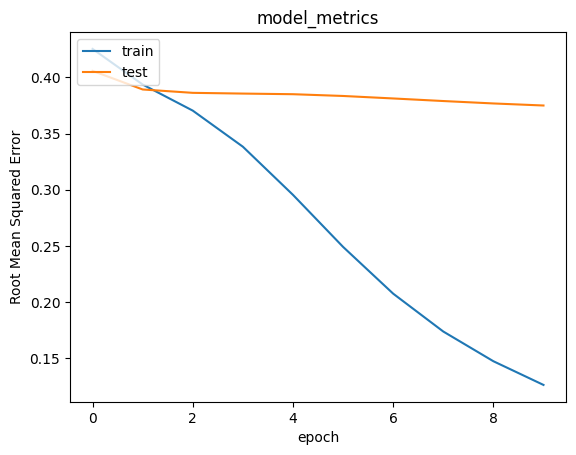

In [23]:
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model_metrics')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Penjelasan :**

Terlihat bahwa model yang dibangun cenderung overfitting. Hal ini dilihat dar nilai evaluasi pada data uji dan data latih yang cukup besar Gap nya setelah beberapa epoch. 

### 4.2.4 Merekomendasikan Buku

In [24]:
def recommend_books_for_user(model, user_id_asli, data, buku_df, user_to_user_encoded, buku_to_ids_encoded, ids_to_buku_encoded, top_n=10):
    # Cek apakah user_id valid
    if user_id_asli not in user_to_user_encoded:
        print("User ID tidak ditemukan.")
        return []

    user_encoded = user_to_user_encoded[user_id_asli]
    buku_user_sudah_rating = data[data['userID'] == user_id_asli]['ISBN'].tolist()
    buku_user_sudah_encoded = [buku_to_ids_encoded[buku] for buku in buku_user_sudah_rating]

    # Semua buku yang belum diberi rating oleh user
    buku_tidak_dirating = list(set(buku_to_ids_encoded.values()) - set(buku_user_sudah_encoded))
    user_encoded_array = np.full(len(buku_tidak_dirating), user_encoded)
    
    # Membuat data pasangan user-buku
    input_pairs = np.array(list(zip(user_encoded_array, buku_tidak_dirating)))

    # Prediksi skor
    ratings = model.predict(input_pairs).flatten()
    
    # Ambil top-N
    top_indices = ratings.argsort()[-top_n:][::-1]
    top_buku_encoded = [buku_tidak_dirating[i] for i in top_indices]
    top_buku_isbn = [ids_to_buku_encoded[i] for i in top_buku_encoded]

    # Gabungkan dengan info buku (jika ada dataframe buku_df)
    rekomendasi = buku_df[buku_df['ISBN'].isin(top_buku_isbn)].copy() if buku_df is not None else pd.DataFrame({'ISBN': top_buku_isbn})
    rekomendasi['Predicted_Score'] = ratings[top_indices]
    
    return rekomendasi.sort_values(by='Predicted_Score', ascending=False)

# Menampilkan 5 userID unik pertama dari data
sample_user_ids = dataFinal['userID'].unique()[:5]
user_id_sample = sample_user_ids[0]  # atau pilih indeks lain

# Contoh penggunaan:
rekomendasi_df = recommend_books_for_user(model, user_id_asli=user_id_sample, data=dataFinal, buku_df=dataBuku,
    user_to_user_encoded=user_to_user_encoded,
    buku_to_ids_encoded=buku_to_ids_encoded,
    ids_to_buku_encoded=ids_to_buku_encoded,
    top_n=5)

# Tampilkan hasil
display(rekomendasi_df)


7157/7157 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Predicted_Score
31764,0345338499,Black Mountain Breakdown,Lee Smith,1986,Ballantine Books,http://images.amazon.com/images/P/0345338499.0...,http://images.amazon.com/images/P/0345338499.0...,http://images.amazon.com/images/P/0345338499.0...,0.631545
42173,0590847678,Diary of a Mad Mummy (Give Yourself Goosebumps...,R. L. Stine,1996,Scholastic,http://images.amazon.com/images/P/0590847678.0...,http://images.amazon.com/images/P/0590847678.0...,http://images.amazon.com/images/P/0590847678.0...,0.607517
58839,0345435729,"Morgawr (The Voyage of the Jerle Shannara, Boo...",Terry Brooks,2002,Del Rey Books,http://images.amazon.com/images/P/0345435729.0...,http://images.amazon.com/images/P/0345435729.0...,http://images.amazon.com/images/P/0345435729.0...,0.597221
100950,0449224430,Prince and the Pilgrim (Classics of Arthurian ...,Mary Stewart,1997,Ivy Books,http://images.amazon.com/images/P/0449224430.0...,http://images.amazon.com/images/P/0449224430.0...,http://images.amazon.com/images/P/0449224430.0...,0.589076
193472,1901746178,Atkinson for England,Gary James,2001,Empire Publications,http://images.amazon.com/images/P/1901746178.0...,http://images.amazon.com/images/P/1901746178.0...,http://images.amazon.com/images/P/1901746178.0...,0.584324


**Penjelasan :**

Berdasarkan pengujian yang dilakukan terhadap sistem rekomendasi yang dibangun dengan RecommenderNet, terlihat bahwa sistem dapat mengembalikan daftar Buku melalui karakteristik buku disertai prediksi rating yang telah distandardisasi.

## 4.3.1 Pendefinisian Model Rekomendasi dengan Catboost

In [26]:
def sistemRekomendasiCatboost(x_train, y_train, x_val, y_val, n_trials=10, random_state=42):
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'random_state': random_state,
            'verbose': 0
        }

        model = CatBoostRegressor(**params)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        return rmse

    # Optimasi dengan Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    print("Best Parameters:", study.best_params)
    print("Best RMSE:", study.best_value)

    # Latih ulang model terbaik
    best_params = study.best_params

    best_model = CatBoostRegressor(**best_params)
    best_model.fit(x_train, y_train)

    return best_model, study


### 4.3.2 Rekomendasi Buku

In [30]:
def recommend_books_cb(
    model, 
    user_id_asli, 
    data, 
    buku_df, 
    user_to_user_encoded, 
    buku_to_ids_encoded, 
    ids_to_buku_encoded, 
    top_n=5
):
    if user_id_asli not in user_to_user_encoded:
        return pd.DataFrame()

    user_enc = user_to_user_encoded[user_id_asli]
    all_buku_encoded = list(buku_to_ids_encoded.values())

    # Buat kombinasi user_encoded dengan semua buku_encoded
    user_buku_pairs = np.array([[user_enc, buku_enc] for buku_enc in all_buku_encoded])

    # Prediksi rating
    pred_ratings = model.predict(user_buku_pairs)

    # Ambil top_n hasil
    top_indices = np.argsort(pred_ratings)[::-1][:top_n]
    top_buku_encoded = [all_buku_encoded[i] for i in top_indices]

    top_isbns = [ids_to_buku_encoded[enc] for enc in top_buku_encoded]
    top_pred_scores = pred_ratings[top_indices]

    # Buat DataFrame hasil rekomendasi
    recommendations = pd.DataFrame({
        'ISBN': top_isbns,
        'predicted_rating': top_pred_scores
    })

    # Merge dengan buku_df untuk menambahkan informasi buku
    buku_info_cols = ['ISBN', 'Book-Title', 'Book-Author', 'Publisher', 'Year-Of-Publication']
    final_df = recommendations.merge(buku_df[buku_info_cols], on='ISBN', how='left')

    return final_df


### 4.3.3 Pengujian Sistem Rekomendasi

In [28]:
model_cb, study = sistemRekomendasiCatboost(x_train, y_train, x_val, y_val)

[I 2025-06-05 12:14:30,303] A new study created in memory with name: no-name-e128ad1c-bb11-464a-a4e5-de2030b7a3ad
[I 2025-06-05 12:14:42,913] Trial 0 finished with value: 0.3796866466243356 and parameters: {'iterations': 345, 'learning_rate': 0.0226625105006579, 'l2_leaf_reg': 4.955792512126149}. Best is trial 0 with value: 0.3796866466243356.
[I 2025-06-05 12:15:03,042] Trial 1 finished with value: 0.3763531349989974 and parameters: {'iterations': 555, 'learning_rate': 0.05150404871098737, 'l2_leaf_reg': 2.38454003589604}. Best is trial 1 with value: 0.3763531349989974.
[I 2025-06-05 12:15:33,097] Trial 2 finished with value: 0.378612522344225 and parameters: {'iterations': 805, 'learning_rate': 0.01546825116828125, 'l2_leaf_reg': 2.119195737814583}. Best is trial 1 with value: 0.3763531349989974.
[I 2025-06-05 12:15:44,480] Trial 3 finished with value: 0.37801265602098183 and parameters: {'iterations': 283, 'learning_rate': 0.05609723075903076, 'l2_leaf_reg': 6.0635939275679505}. Bes

Best Parameters: {'iterations': 519, 'learning_rate': 0.1844464136719036, 'l2_leaf_reg': 6.752485483360803}
Best RMSE: 0.37416850201595
0:	learn: 0.3850927	total: 50.1ms	remaining: 25.9s
1:	learn: 0.3842042	total: 94.3ms	remaining: 24.4s
2:	learn: 0.3839225	total: 134ms	remaining: 23.1s
3:	learn: 0.3832600	total: 178ms	remaining: 23s
4:	learn: 0.3830814	total: 222ms	remaining: 22.8s
5:	learn: 0.3826959	total: 262ms	remaining: 22.4s
6:	learn: 0.3824208	total: 299ms	remaining: 21.9s
7:	learn: 0.3823195	total: 328ms	remaining: 21s
8:	learn: 0.3822269	total: 358ms	remaining: 20.3s
9:	learn: 0.3819327	total: 393ms	remaining: 20s
10:	learn: 0.3817111	total: 429ms	remaining: 19.8s
11:	learn: 0.3815748	total: 465ms	remaining: 19.6s
12:	learn: 0.3813527	total: 502ms	remaining: 19.5s
13:	learn: 0.3812849	total: 538ms	remaining: 19.4s
14:	learn: 0.3811304	total: 573ms	remaining: 19.2s
15:	learn: 0.3809814	total: 614ms	remaining: 19.3s
16:	learn: 0.3808185	total: 648ms	remaining: 19.1s
17:	learn: 

In [32]:
# Ambil 1 user unik dari data
sample_user = dataFinal['userID'].iloc[0]
print("Sample user:", sample_user)
top_books = recommend_books_cb(model_cb, sample_user, dataFinal, dataBuku, user_to_user_encoded, buku_to_ids_encoded, ids_to_buku_encoded, top_n=5)
top_books

Sample user: 276727


,ISBN,predicted_rating,Book-Title,Book-Author,Publisher,Year-Of-Publication
0,3453116569,0.832223,Verlorene Sellen,Barbara Bellingen,Wilhelm Heyne Verlag GmbH &amp; Co KG,1998
1,0812558006,0.832223,Firechild,Jack Williamson,Tor Books,1987
2,0674242416,0.832223,Einstein's Greatest Blunder?: The Cosmological...,Donald Goldsmith,Harvard University Press,1995
3,0689305370,0.832223,"Anywhere, Anywhen : Stories of Tomorrow",Sylvia Louise Engdahl,Atheneum,1976
4,0812523822,0.832223,To Fear The Light : The sequel to 'To Save the...,Ben Bova,Tor Science Fiction,1996


**Penjelasan :**

Berdasarkan pengujian yang dilakukan terhadap sistem rekomendasi yang dibangun dengan Algoritma Catboost, terlihat bahwa sistem dapat mengembalikan daftar Buku melalui nilai ISBN nya.

# 5. Evaluasi

## 5.1 Evaluasi Content Based Filtering : Cosine Similarity

In [ ]:
def evaluate_cbf_recommender(dataBaru, recommend_fn, users_to_evaluate, k=5):
    results = []
    user_books = dataBaru.groupby("userID")["Book-Title"].apply(set).to_dict()

    for user in users_to_evaluate:
        books_read = list(user_books.get(user, []))
        if not books_read:
            continue
        seed_book = pd.Series(books_read).dropna().sample(1).iloc[0]
        try:
            rec_df = recommend_fn(seed_book, cosine_sim, len(books_read))
        except:
            continue
        rec_books = rec_df["Book-Title"].tolist()[:k]
        actual_books = set(books_read)
        relevance_vector = [1 if book in actual_books else 0 for book in rec_books]
        true_positives = sum(relevance_vector)

        precision = true_positives / k if k > 0 else 0
        recall = true_positives / len(actual_books) if actual_books else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        hit_rate = 1 if true_positives > 0 else 0

        results.append({
            "userID": user,
            "seed_book": seed_book,
            "recommended": rec_books,
            "actual": list(actual_books),
            "relevance_vector": relevance_vector,
            "precision@k": precision,
            "recall@k": recall,
            "f1_score@k": f1_score,
            "hit_rate@k": hit_rate
        })

    results_df = pd.DataFrame(results)
    avg_precision = results_df["precision@k"].mean()
    avg_recall = results_df["recall@k"].mean()
    avg_f1 = results_df["f1_score@k"].mean()
    avg_hit_rate = results_df["hit_rate@k"].mean()

    return results_df, avg_precision, avg_recall, avg_f1, avg_hit_rate

# Hitung jumlah buku per user
user_book_counts = dataBaru.groupby("userID")["Book-Title"].nunique()

# Filter user dengan minimal 5 buku
eligible_users = user_book_counts[user_book_counts >= 5].index.tolist()

# Ambil sample user dari yang eligible
sample_users = random.sample(eligible_users, 10)

# Jalankan evaluasi
results_df, avg_prec, avg_rec, avg_f1, avg_hr = evaluate_cbf_recommender(dataBaru, recommend, sample_users, k=5)

print(f"Avg Precision@5: {avg_prec:.4f}")
print(f"Avg Recall@5: {avg_rec:.4f}")
print(f"Avg F1-Score@5: {avg_f1:.4f}")
print(f"Avg Hit Rate@5: {avg_hr:.4f}")

results_df.head()


Menampilkan Rekomendasi Buku yang sesuai dengan 'Le neveu d'AmÃ?Â©rique' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'Misterio en el Caribe' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'The Catcher in the Rye' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'Big Stone Gap: A Novel (Ballantine Reader's Circle)' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'The Templar Treasure (Adept)' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'Are We Living in the End Times?' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'WORLD ABLAZE (MEN AT ARMS 3) : WORLD ABLAZE (Men at Arms, Bk 3)' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'Justine, Philosophy in the Bedroom and Other Writings' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'Rocks, Gems and Minerals : A Golden Guide from St. Martin's Press (Golden Guide from St. Martin's Press)' ...
Menampilkan Rekomendasi Buku yang sesuai dengan 'Como Se Dice' ...
Avg Precision@5: 0.0200
Avg Recall@5: 0.020

,userID,seed_book,recommended,actual,relevance_vector,precision@k,recall@k,f1_score@k,hit_rate@k
0,643,Le neveu d'AmÃ?Â©rique,"[Le livre de sable, Jorge Luis Borges: Ficcion...","[Les Orientales ; Les Feuilles d'automne, How ...","[0, 0, 0, 0, 0]",0.0,0.0,0.0,0
1,203820,Misterio en el Caribe,[El misterio del perro secuestrado (Resuelve e...,[El Caballero De Olmedo (Biblioteca Didactica ...,"[0, 0, 0, 0, 0]",0.0,0.0,0.0,0
2,117594,The Catcher in the Rye,"[The Catcher in the Rye, Catcher in the Rye, N...","[A Nothing Town in Texas, The 500-Year Delta: ...","[1, 0, 0, 0, 0]",0.2,0.2,0.2,1
3,185147,Big Stone Gap: A Novel (Ballantine Reader's Ci...,[Big Cherry Holler: A Big Stone Gap Novel (Bal...,"[She Moves Through the Boom, Roger Fishbite: A...","[0, 0, 0, 0, 0]",0.0,0.0,0.0,0
4,207494,The Templar Treasure (Adept),"[The Adept (Adept), Tales of the Knights Templ...","[Cyber Way, The Templar Treasure (Adept), Ever...","[0, 0, 0, 0, 0]",0.0,0.0,0.0,0


**Penjelasan :**

Berdasarkan ukuran evaluasi yang didefinisikan, kedua sistem rekomendasi yang dibangun dievaluasi untuk mengetahui seberapa baik sistem dapat memberikan rekomendasi pengguna berdasarkan konten yang serupa ataupun preferensi pengguna lain yang mirip. 
Pada Content Based Filtering, sistem dievaluasi terhadap 10 pengguna diperoleh ukuran evaluasi rata-rata sebagai berikut.

Avg Precision@5: 0.0200<br>
Avg Recall@5: 0.0200<br>
Avg F1-Score@5: 0.0200<br>
Avg Hit Rate@5: 0.1000<br>

## 5.2 Evaluasi Colaborative Filtering

### Recommender Net

In [ ]:
def evaluate_cf_model(
    model, 
    x_val, 
    y_val, 
    dataFinal, 
    buku_df,
    user_to_user_encoded, 
    buku_to_ids_encoded, 
    ids_to_buku_encoded, 
    k=5
):
    # Buat DataFrame val dari x_val dan y_val
    val_df = pd.DataFrame({
        "user_encoded": x_val[:, 0],
        "buku_encoded": x_val[:, 1],
        "interaction": y_val
    })

    # Filter interaksi positif
    val_pos_df = val_df[val_df["interaction"] > 0]

    # Mapping user_encoded -> set buku_encoded
    user_items_val = val_pos_df.groupby("user_encoded")["buku_encoded"].apply(set).to_dict()

    # Ambil 10 user secara acak
    users_to_eval = list(user_items_val.keys())
    if len(users_to_eval) > 10:
        users_to_eval = random.sample(users_to_eval, 10)

    results = []

    for user_encoded in users_to_eval:
        user_id_asli = next((k_ for k_, v_ in user_to_user_encoded.items() if v_ == user_encoded), None)
        if user_id_asli is None:
            continue

        actual_items = user_items_val[user_encoded]

        rekomendasi_df = recommend_books_for_user(
            model=model,
            user_id_asli=user_id_asli,
            data=dataFinal,
            buku_df=buku_df,
            user_to_user_encoded=user_to_user_encoded,
            buku_to_ids_encoded=buku_to_ids_encoded,
            ids_to_buku_encoded=ids_to_buku_encoded,
            top_n=k
        )

        rec_books_encoded = [
            buku_to_ids_encoded[isbn] for isbn in rekomendasi_df['ISBN'] if isbn in buku_to_ids_encoded
        ] if not rekomendasi_df.empty else []

        relevance_vector = [1 if book in actual_items else 0 for book in rec_books_encoded]
        true_positives = sum(relevance_vector)

        precision = true_positives / k if k > 0 else 0
        recall = true_positives / len(actual_items) if actual_items else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        hit_rate = 1 if true_positives > 0 else 0

        results.append({
            "user_encoded": user_encoded,
            "user_id_asli": user_id_asli,
            "recommended_encoded": rec_books_encoded,
            "actual_encoded": list(actual_items),
            "relevance_vector": relevance_vector,
            "precision@k": precision,
            "recall@k": recall,
            "f1_score@k": f1_score,
            "hit_rate@k": hit_rate
        })

    results_df = pd.DataFrame(results)
    avg_precision = results_df["precision@k"].mean()
    avg_recall = results_df["recall@k"].mean()
    avg_f1 = results_df["f1_score@k"].mean()
    avg_hit_rate = results_df["hit_rate@k"].mean()

    # Hitung RMSE pada seluruh validation set
    y_pred = model.predict(x_val).flatten()
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return results_df, avg_precision, avg_recall, avg_f1, avg_hit_rate, rmse

In [30]:
results_df, avg_prec, avg_rec, avg_f1, avg_hr, rmse = evaluate_cf_model(
    model, x_val, y_val, dataFinal, dataBuku,
    user_to_user_encoded, buku_to_ids_encoded, ids_to_buku_encoded,
    k=5
)

print(f"Avg Precision@5: {avg_prec:.4f}")
print(f"Avg Recall@5: {avg_rec:.4f}")
print(f"Avg F1-Score@5: {avg_f1:.4f}")
print(f"Avg Hit Rate@5: {avg_hr:.4f}")
print(f"RMSE: {rmse:.4f}")


7155/7155 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7156/7156 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7157/7157 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7156/7156 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7157/7157 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7157/7157 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7156/7156 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7156/7156 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7156/7156 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
7154/7154 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
4709/4709 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
Avg Precision@5: 0.0000
Avg Recall@5: 0.0000
Avg F1-Score@5: 0.0000
Avg Hit Rate@5: 0.0000
RMSE: 0.3749


### Sistem Rekomendasi CatBoost

In [31]:
def evaluate_cb(
    model, 
    x_val, 
    y_val, 
    dataFinal, 
    buku_df,
    user_to_user_encoded, 
    buku_to_ids_encoded, 
    ids_to_buku_encoded, 
    k=5
):
    val_df = pd.DataFrame({
        "user_encoded": x_val[:, 0],
        "buku_encoded": x_val[:, 1],
        "interaction": y_val
    })

    val_pos_df = val_df[val_df["interaction"] > 0]
    user_items_val = val_pos_df.groupby("user_encoded")["buku_encoded"].apply(set).to_dict()

    users_to_eval = list(user_items_val.keys())
    if len(users_to_eval) > 10:
        users_to_eval = random.sample(users_to_eval, 10)

    results = []

    for user_encoded in users_to_eval:
        user_id_asli = next((k_ for k_, v_ in user_to_user_encoded.items() if v_ == user_encoded), None)
        if user_id_asli is None:
            continue

        actual_items = user_items_val[user_encoded]

        rekomendasi_df = recommend_books_cb(
            model=model,
            user_id_asli=user_id_asli,
            data=dataFinal,
            buku_df=buku_df,
            user_to_user_encoded=user_to_user_encoded,
            buku_to_ids_encoded=buku_to_ids_encoded,
            ids_to_buku_encoded=ids_to_buku_encoded,
            top_n=k
        )

        rec_books_encoded = [
            buku_to_ids_encoded[isbn] for isbn in rekomendasi_df['ISBN'] if isbn in buku_to_ids_encoded
        ] if not rekomendasi_df.empty else []

        relevance_vector = [1 if book in actual_items else 0 for book in rec_books_encoded]
        true_positives = sum(relevance_vector)

        precision = true_positives / k if k > 0 else 0
        recall = true_positives / len(actual_items) if actual_items else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        hit_rate = 1 if true_positives > 0 else 0

        results.append({
            "user_encoded": user_encoded,
            "user_id_asli": user_id_asli,
            "recommended_encoded": rec_books_encoded,
            "actual_encoded": list(actual_items),
            "relevance_vector": relevance_vector,
            "precision@k": precision,
            "recall@k": recall,
            "f1_score@k": f1_score,
            "hit_rate@k": hit_rate
        })

    results_df = pd.DataFrame(results)
    avg_precision = results_df["precision@k"].mean()
    avg_recall = results_df["recall@k"].mean()
    avg_f1 = results_df["f1_score@k"].mean()
    avg_hit_rate = results_df["hit_rate@k"].mean()

    y_pred = model.predict(x_val).flatten()
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return results_df, avg_precision, avg_recall, avg_f1, avg_hit_rate, rmse

In [32]:
results_df, avg_prec, avg_rec, avg_f1, avg_hit, rmse = evaluate_cb(
    model_cb,
    x_val,
    y_val,
    dataFinal,
    dataBuku,
    user_to_user_encoded,
    buku_to_ids_encoded,
    ids_to_buku_encoded,
    k=5
)

print(f"Precision@5: {avg_prec:.4f}")
print(f"Recall@5: {avg_rec:.4f}")
print(f"F1-score@5: {avg_f1:.4f}")
print(f"Hit Rate@5: {avg_hit:.4f}")
print(f"RMSE: {rmse:.4f}")

Precision@5: 0.0000
Recall@5: 0.0000
F1-score@5: 0.0000
Hit Rate@5: 0.0000
RMSE: 0.3741


**Penjelasan :**

Pada Collaborative Filtering menggunakan RecommenderNet dan Algoritma Catboost, model dievaluasi terhadap pengguna yang didefinisikan pada validation set, diperoleh evaluasi sebagai berikut.

=====Recommender Net====

RMSE: 0.3749

=====CatBoost=====

RMSE: 0.3741

Berdasarkan kedua jenis sistem rekomendasi yang dibangun, terlihat model masih belum cukup baik untuk memberikan rekomendasi pada user, namun sudah memiliki keterkaitan dengan konsep yang digunakan. Hal ini dapat dilihat pada Content Based Filtering, hasil return untuk input user pada judul atau author buku tertentu sesuai dengan hasil yang diharapkan. Kondisi yang membuat evaluasi kecil dapat terjadi karena terdapat kecenderungan data user yang membeli buku secara acak, bukan berdasarkan kesamaan karakteristiknya.

Selain itu pada Collaborative filtering diperoleh bahwa CatBoost memiliki performa sistem rekomendasi yang lebih baik dibandingkan dengan sistem rekomendasi yang dihasilkan RecommenderNet. Hal ini menunjukkan bahwa Machine Learning tidak selalu lebih buruk performanya dibanding Deep Learning pada dataset yang besar.